<a href="https://colab.research.google.com/github/dyna-bytes/PyTorchIntensive/blob/main/4_5_2_VGG_Fine_Tuning_ImageGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 변수의 shape, type, value 확인
def p(var,_str='') :
    if _str=='\n' or _str=='cr' :
        _str = '\n'
    else :
        print(f'[{_str}]:')
        _str = ''
    if type(var)!=type([]):
        try:
            print(f'Shape:{var.shape}')
        except :
            pass
    print(f'Type: {type(var)}')
    print(f'Values: {var}'+_str)

def pst(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}, {type(_x)}')
def ps(_x,_name=""):
    print(f'[{_name}] Shape{_x.shape}')

In [ ]:
%%capture
!pip install pytorch_lightning torchinfo torchmetrics pandas torchviz

# 실습 2 : VGG Model Fine Tuning + ImageGenerator

## Import Module

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import cross_entropy

from torch.utils.data import DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import functional as FM
from torchinfo import summary
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.loggers import CSVLogger
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from IPython import display
plt.rcParams['figure.figsize'] = [5, 3.5]

device ='cuda:0'
torch.__version__

'2.0.1+cu118'

## **Dataset Load**

In [ ]:
from torchvision.datasets.utils import download_and_extract_archive
import pathlib
dataset_url = \
      "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
root = './'
data_dir='Dataset'
download_and_extract_archive(dataset_url, root, data_dir)
data_dir = root+data_dir+'/flower_photos'
data_dir

100%|██████████| 228813984/228813984 [00:01<00:00, 136613145.65it/s]


Extracting ./flower_photos.tgz to Dataset


'./Dataset/flower_photos'

In [ ]:
!ls {data_dir}

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [ ]:
!rm -r 'flower_photos_sp'

rm: cannot remove 'flower_photos_sp': No such file or directory


### Train / Test Data split

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders
sp_path="flower_photos_sp"
splitfolders.ratio(data_dir, output=sp_path,
    seed=1337, ratio=(.7, .3), group_prefix=None, move=True )
sp_train = pathlib.Path(sp_path+'/train')
sp_test = pathlib.Path(sp_path+'/val')
sp_train

Copying files: 3670 files [00:00, 10887.35 files/s]


PosixPath('flower_photos_sp/train')

### Check Images

In [ ]:
# 지정 폴더 아래에 있는 모든 *.jpg 파일의 수
#  및 폴더명 목록을 리턴
def check_dir(d_path):
    img_count = len(list(d_path.glob('*/*.jpg')))
    c_name = np.array([item.name for item in d_path.glob('*') if item.name != "LICENSE.txt"])
    return img_count, c_name, len(c_name)

# check_dir()로 폴더명과 이미지 숫자 확인
image_count, CLASS_train, class_num = check_dir(sp_train)
CLASS_train.sort()
print('Train image_count: {}\nclasses: {}'.format(image_count, CLASS_train))
image_count, CLASS_test, class_num = check_dir(sp_test)
CLASS_test.sort()
print('Test image_count: {}\nclasses: {}'.format(image_count, CLASS_test))

Train image_count: 2567
classes: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
Test image_count: 1103
classes: ['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
# 지정 path 아래에 있는 폴더에서 이미지 두장씩을 확인
def check_image(d_path, class_list):
    for i in range(len(class_list)):
        class_temp = list(d_path.glob(str(class_list[i])+'/*'))
        for image_path in class_temp[:2]:
            display.display(Image.open(str(image_path)))
# check_image()로 이미지 두장씩 확인
check_image(sp_train, CLASS_train)

### ImageDataGenerator 만들기

In [ ]:
# Imagae size 결정 **
IN_IMG_SIZE = 112
batch_n = 32

In [ ]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## loader에 적용할 transform
_transforms = transforms.Compose([transforms.Resize((IN_IMG_SIZE, IN_IMG_SIZE)),
                              # transforms.RandomAffine(degrees=40, translate=(0.2, 0.2), shear=0.2),
                              # transforms.RandomResizedCrop(IN_IMG_SIZE, scale=[0.2, 1.0]),
                              #  transforms.RandomHorizontalFlip(0.5),
                                  transforms.ToTensor()])
## ImageFolder : folder로 구성된 image set을 위한 loader
train_imgs = ImageFolder(sp_train, transform=_transforms) #(image,label)
test_imgs = ImageFolder(sp_test, transform=_transforms)
## DataLoader : dataset과 sampler를 결합 batch단위 제공 #(image,label)*batch
train_loader = DataLoader(train_imgs, batch_size=batch_n, shuffle=True,num_workers=4)
test_loader = DataLoader(test_imgs, batch_size=batch_n, shuffle=False,num_workers=4)

len(train_imgs),len(test_imgs)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(2567, 1103)

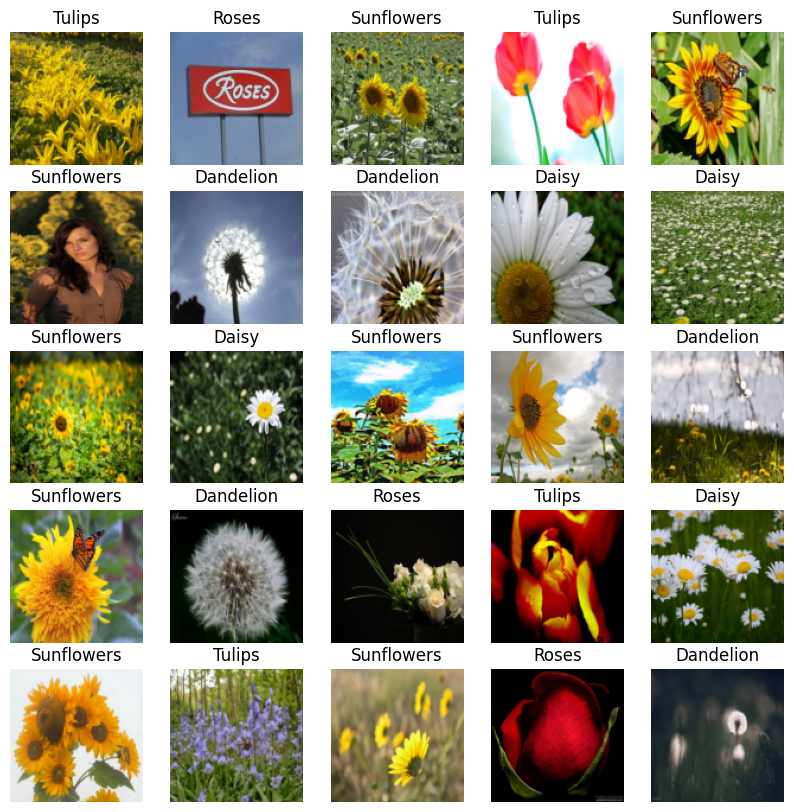

In [ ]:
def show_batch(data_gen, class_l):
    # get image and label from data generator
    img_batch, l_batch = next(iter(data_gen))
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(img_batch[n].permute(1, 2, 0))
        plt.title(class_l[l_batch[n]].title())
        plt.axis('off')
    return img_batch, l_batch

# check dataset
_,_ = show_batch(train_loader, CLASS_train)

## **Load VGG16 model**

- conv layer만 loading: `include_top=True` option 사용
- input image size: `input_tensor=` keyword param 사용 -> 48 x 48 input shape의 model load

In [ ]:
vgg16 = torchvision.models.vgg16(pretrained=True)
model_vgg = vgg16.features
summary(model_vgg, input_size=(batch_n, 3, IN_IMG_SIZE, IN_IMG_SIZE))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 307MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [32, 512, 3, 3]           --
├─Conv2d: 1-1                            [32, 64, 112, 112]        1,792
├─ReLU: 1-2                              [32, 64, 112, 112]        --
├─Conv2d: 1-3                            [32, 64, 112, 112]        36,928
├─ReLU: 1-4                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-5                         [32, 64, 56, 56]          --
├─Conv2d: 1-6                            [32, 128, 56, 56]         73,856
├─ReLU: 1-7                              [32, 128, 56, 56]         --
├─Conv2d: 1-8                            [32, 128, 56, 56]         147,584
├─ReLU: 1-9                              [32, 128, 56, 56]         --
├─MaxPool2d: 1-10                        [32, 128, 28, 28]         --
├─Conv2d: 1-11                           [32, 256, 28, 28]         295,168
├─ReLU: 1-12                             [32, 256, 28, 28]      

### **마지막 `conv block`만 남기고 나머지는 전부 freeze**
- ### 마지막 conv block이 fine tuning 됨


In [ ]:
vgg16_ = vgg16.features
for i, child in enumerate(vgg16_.children()):
  if i < len(vgg16_) - 7:
    # Freeze the layers except the last 7 layers
    for param in child.parameters():
      param.requires_grad = False
  else :
    print(child)

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU(inplace=True)
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [ ]:
for child in vgg16_.children():
    for param in child.parameters():
        print(child, param.requires_grad)
        break

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) False
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)) True


### **VGG 결과를 받아 dense(relu) + dropout + dense(softmax)를 추가하여 classification model 완성**
- ***batch normalizatin을 필히 사용할 것***

In [ ]:
loss_function = nn.CrossEntropyLoss()

class VGGFineTune2(pl.LightningModule):
    def __init__(self, vggnet, num_classes=10):
        super(VGGFineTune2, self).__init__()
        self.features = vggnet
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*3*3,512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.1),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.linear(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task='multiclass', num_classes=5)
        metrics={'loss':loss, 'acc':acc}
        self.log_dict(metrics,prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = loss_function(y_pred, y)
        acc = FM.accuracy(y_pred, y, task='multiclass', num_classes=5)
        metrics = {'val_loss':loss, 'val_acc':acc}
        self.log_dict(metrics,prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

vggFineTune2 = VGGFineTune2(model_vgg, class_num)
summary(vggFineTune2, input_size=(batch_n, 3, IN_IMG_SIZE, IN_IMG_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
VGGFineTune2                             [32, 5]                   --
├─Sequential: 1-1                        [32, 512, 3, 3]           --
│    └─Conv2d: 2-1                       [32, 64, 112, 112]        (1,792)
│    └─ReLU: 2-2                         [32, 64, 112, 112]        --
│    └─Conv2d: 2-3                       [32, 64, 112, 112]        (36,928)
│    └─ReLU: 2-4                         [32, 64, 112, 112]        --
│    └─MaxPool2d: 2-5                    [32, 64, 56, 56]          --
│    └─Conv2d: 2-6                       [32, 128, 56, 56]         (73,856)
│    └─ReLU: 2-7                         [32, 128, 56, 56]         --
│    └─Conv2d: 2-8                       [32, 128, 56, 56]         (147,584)
│    └─ReLU: 2-9                         [32, 128, 56, 56]         --
│    └─MaxPool2d: 2-10                   [32, 128, 28, 28]         --
│    └─Conv2d: 2-11                      [32, 256, 28, 28]   

## **Fit**

In [ ]:
%%time
vggFineTune2 = VGGFineTune2(model_vgg, class_num)

epochs=5
logger = CSVLogger("logs", name="VGGNetFineTune_2")
trainer = Trainer(max_epochs=epochs, logger=logger, accelerator='auto')
trainer.fit(vggFineTune2, train_loader, val_dataloaders=test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type       | Params
----------------------------------------
0 | features | Sequential | 14.7 M
1 | linear   | Sequential | 2.4 M 
----------------------------------------
9.4 M     Trainable params
7.6 M     Non-trainable params
17.1 M    Total params
68.312    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


CPU times: user 14.5 s, sys: 3.43 s, total: 17.9 s
Wall time: 1min 16s


Epoch 4: 100%
81/81 [00:21<00:00, 3.77it/s, v_num=0]
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
CPU times: user 1min 38s, sys: 2.45 s, total: 1min 40s
Wall time: 1min 45s

## **Analysis**

In [ ]:
v_num = logger.version

history = pd.read_csv(f'./logs/VGGNetFineTune_2/version_{v_num}/metrics.csv')
history_plot = history.drop('step', axis=1).groupby('epoch').last()
print('\t',np.max(history_plot['val_acc']))

	 0.8857660889625549


0.8785131573677063

In [ ]:
history_plot

,loss,acc,val_loss,val_acc
epoch,,,,
0,0.741047,0.71875,0.414855,0.854941
1,0.441789,0.84375,0.360803,0.873073
2,0.038462,1.00000,0.340269,0.880326
3,0.033659,1.00000,0.342941,0.881233
4,0.006306,1.00000,0.342452,0.885766


0.8857660889625549


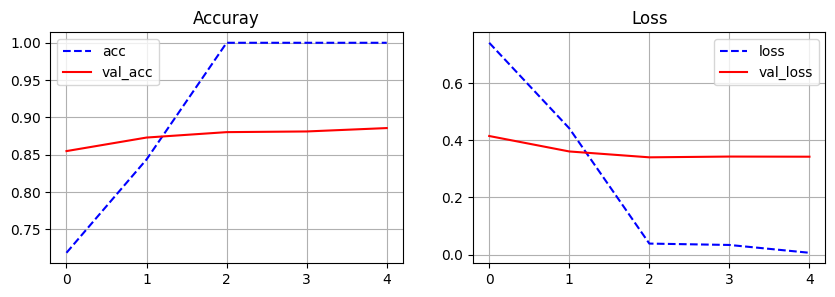

In [ ]:
history = history_plot

print(np.max(history['val_acc']))

plt.figure(figsize=(10, 3.))
plt.subplot(121)
plt.title('Accuray')
plt.plot( history['acc'], 'b--', label='acc')
plt.plot( history['val_acc'], 'r', label='val_acc')
plt.grid()
#    plt.ylim([0.6, 1])
plt.legend()

plt.subplot(122)
plt.title('Loss')
plt.plot( history['loss'], 'b--', label='loss')
plt.plot( history['val_loss'], 'r', label='val_loss')
plt.grid()
#plt.ylim([0.0, 0.6])
plt.legend()
plt.show()

 0.8966454863548279
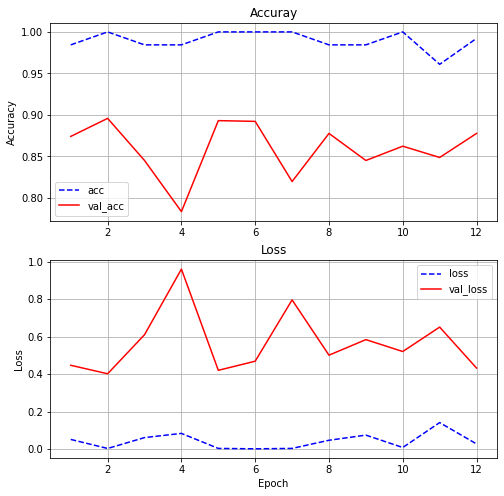

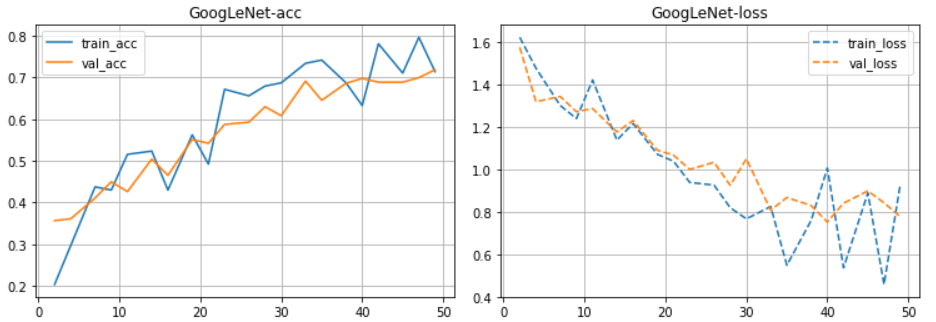

## **Prediction result with test image**

In [ ]:
np.random.randint(0,len(test_imgs),n_plot)

NameError: ignored

In [ ]:
n_plot = 10
idx = np.random.randint(0,len(test_imgs),n_plot)

plt.figure(figsize=(3*n_plot, n_plot))
vggFineTune2.eval()
for i,img_idx in enumerate(idx):
    predict = vggFineTune2(test_imgs[img_idx][0].unsqueeze(dim=0)).cpu().detach().numpy()
    img = test_imgs[img_idx][0].permute(1, 2, 0)
    plt.subplot(1,n_plot,i+1)
    plt.imshow(img, cmap='gray')
    plt.title('pre:{}/true:{}'.format(np.argmax(predict),test_imgs[img_idx][1]))
plt.show()

# **실습과제**

**성능개선을 위한 접근 방법을 생각해 보자**
-- 모델의 크기는 적당한가?
-- Freeze하는 레이어는 적당한가?
-- 추가 layer의 수준과 방법은 어떻게 개선할 수 있을까?
== 추가 layer에 average pooling을 사용, 모델의 크기를 줄여 보자
== DataAugmentaion을 적용해 보자